In [117]:
import joblib
import os
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
import time
from tkinter import *
from tkinter import filedialog
from tqdm import tqdm
import itertools
import math

## load up CONTROL predictions

In [118]:
# Create Tk root
root = Tk()
# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
infiles = filedialog.askopenfilename(multiple=True, title='load 1ST predictions npy')

%gui tk

In [119]:
infiles[0]

'Z:/nia_summer_project/data_transfer/P16/091222/VideoOutputCamera 0-12092022-133159_posthoc-predictions.npy'

In [120]:
predictions_control = np.load(infiles[0])

In [121]:
print(f'the first prediction array contained {predictions_control.shape[0]} rows')

the first prediction array contained 41916 rows


## LOAD UP EXPERIMENTAL PREDICTIONS

In [122]:
# Create Tk root
root = Tk()
# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
infiles2 = filedialog.askopenfilename(multiple=True, title='load 2ND predictions npy')

%gui tk

In [123]:
infiles2[0]

'Z:/nia_summer_project/data_transfer/P16/090922/VideoOutputCamera 0-09092022-151651_3_posthoc-predictions.npy'

In [124]:
predictions_exp = np.load(infiles2[0])

In [125]:
print(f'the second prediction array contained {predictions_exp.shape[0]} rows')

the second prediction array contained 14666 rows


## COMPARE

### compare frequency

In [126]:
target_of_interests = np.arange(len(np.unique(predictions_control)))
target_of_interests

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

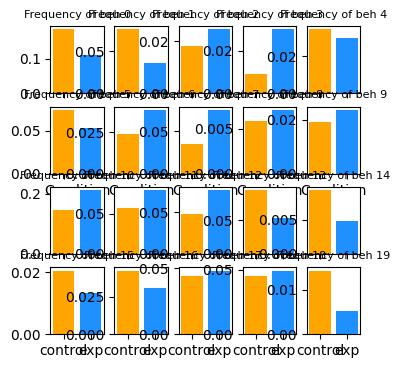

In [127]:
rows = 4
cols = 5
count = 0
fig, ax = plt.subplots(rows, cols, figsize=(4, 4), sharey=False, sharex=True)
for row in range(rows):
    for col in range(cols):
        freq_control = len(np.where(predictions_control == target_of_interests[count])[0])/len(predictions_control)
        freq_exp = len(np.where(predictions_exp == target_of_interests[count])[0])/len(predictions_exp)

        ax[row, col].bar(np.arange(2), [freq_control, freq_exp], color = ['orange', 'dodgerblue'])
        if row == 1:
            ax[row, col].set_xlabel('Condition')
        
        ax[row, col].set_title(f'Frequency of beh {target_of_interests[count]}', fontsize=8)
        ax[row, col].set_xticks(np.arange(2))
        ax[row, col].set_xticklabels(['control', 'exp'])
        count += 1
# for target in target_of_interest:
    
    

In [128]:
target_of_interest = 17

In [129]:
freq_control = len(np.where(predictions_control == target_of_interest)[0])/len(predictions_control)
freq_exp = len(np.where(predictions_exp == target_of_interest)[0])/len(predictions_exp)

[Text(0, 0, 'control'), Text(1, 0, 'exp')]

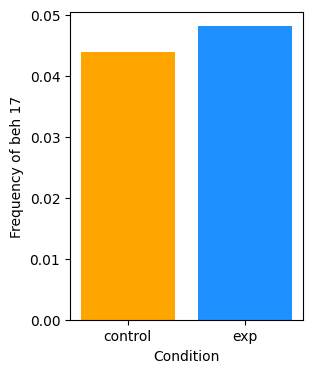

In [130]:
fig, ax = plt.subplots(1, 1, figsize=(3, 4))
ax.bar(np.arange(2), [freq_control, freq_exp], color = ['orange', 'dodgerblue'])
ax.set_xlabel('Condition')
ax.set_ylabel(f'Frequency of beh {target_of_interest}')
ax.set_xticks(np.arange(2))
ax.set_xticklabels(['control', 'exp'])

### compare duration

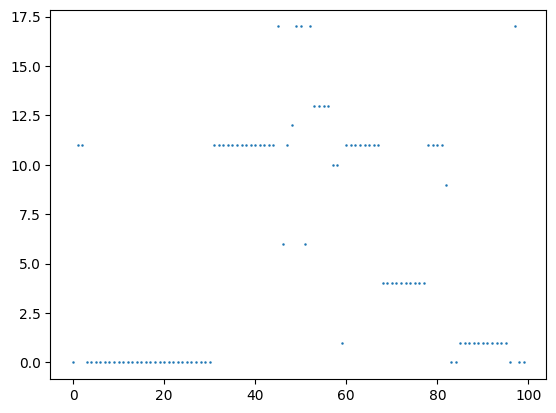

In [131]:
plt.scatter(np.arange(len(predictions_control[:100])), predictions_control[:100], s=0.6)

In [132]:
def weighted_smoothing(predictions, size):
    predictions_new = predictions.copy()
    group_start = [0]
    group_start = np.hstack((group_start, np.where(np.diff(predictions) != 0)[0] + 1))
    for i in range(len(group_start) - 3):
        if group_start[i + 2] - group_start[i + 1] < size:
            if predictions_new[group_start[i + 2]] == predictions_new[group_start[i]] and \
                    predictions_new[group_start[i]:group_start[i + 1]].shape[0] >= size and \
                    predictions_new[group_start[i + 2]:group_start[i + 3]].shape[0] >= size:
                predictions_new[group_start[i]:group_start[i + 2]] = predictions_new[group_start[i]]
    for i in range(len(group_start) - 3):
        if group_start[i + 1] - group_start[i] < size:
            predictions_new[group_start[i]:group_start[i + 1]] = predictions_new[group_start[i] - 1]
    return predictions_new

In [133]:
predictions_control_filtered = weighted_smoothing(predictions_control, size=2)
predictions_exp_filtered = weighted_smoothing(predictions_exp, size=2)

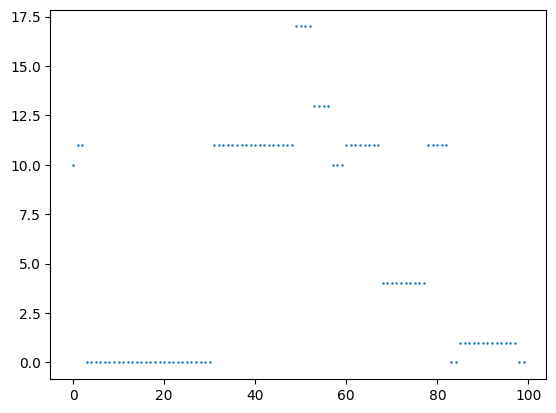

In [134]:
plt.scatter(np.arange(len(predictions_control_filtered[:100])), predictions_control_filtered[:100], s=0.6)

In [135]:
np.hstack((0, np.where(np.diff(predictions_control[:100]) != 0)[0]))

array([ 0,  0,  2, 30, 44, 45, 46, 47, 48, 50, 51, 52, 56, 58, 59, 67, 77,
       81, 82, 84, 95, 96, 97], dtype=int64)

In [136]:
predictions_control[np.where(np.diff(predictions_control[:100]) != 0)[0]]

array([ 0, 11,  0, 11, 17,  6, 11, 12, 17,  6, 17, 13, 10,  1, 11,  4, 11,
        9,  0,  1,  0, 17], dtype=int64)

In [137]:
np.diff(np.hstack((0, np.where(np.diff(predictions_control[:100]) != 0)[0])))

array([ 0,  2, 28, 14,  1,  1,  1,  1,  2,  1,  1,  4,  2,  1,  8, 10,  4,
        1,  2, 11,  1,  1], dtype=int64)

#### putting length with corresponding behavior together

In [138]:
# control
idx_of_interest_control = np.where(predictions_control_filtered[np.where(np.diff(predictions_control_filtered[:]) != 0)[0]] == 17)[0]
durations_all_control = np.diff(np.hstack((0, np.where(np.diff(predictions_control_filtered[:]) != 0)[0])))
# exp
idx_of_interest_exp = np.where(predictions_exp_filtered[np.where(np.diff(predictions_exp_filtered[:]) != 0)[0]] == 17)[0]
durations_all_exp = np.diff(np.hstack((0, np.where(np.diff(predictions_exp_filtered[:]) != 0)[0])))

In [139]:
duration_control = durations_all_control[idx_of_interest_control]
duration_exp = durations_all_exp[idx_of_interest_exp]

In [140]:
duration_control.shape, duration_exp.shape

((405,), (142,))

{'bodies': [<matplotlib.collections.PolyCollection at 0x2460e9eca00>,
  <matplotlib.collections.PolyCollection at 0x2460e9ecd60>]}

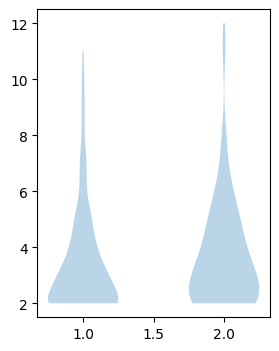

In [141]:
fig, ax = plt.subplots(1, 1, figsize=(3, 4))
ax.violinplot([duration_control, duration_exp], 
              showmeans=False, showextrema=False, showmedians=False)

In [142]:
data_dict = {k: [] for k in ['Condition', 'Duration', 'Behavior']}
for target in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]:
    # control
    idx_of_interest_control = np.where(predictions_control_filtered[np.where(np.diff(predictions_control_filtered[:]) != 0)[0]] == target)[0]
    durations_all_control = np.diff(np.hstack((0, np.where(np.diff(predictions_control_filtered[:]) != 0)[0])))
    # exp
    idx_of_interest_exp = np.where(predictions_exp_filtered[np.where(np.diff(predictions_exp_filtered[:]) != 0)[0]] == target)[0]
    durations_all_exp = np.diff(np.hstack((0, np.where(np.diff(predictions_exp_filtered[:]) != 0)[0])))
    duration_control = durations_all_control[idx_of_interest_control]
    duration_exp = durations_all_exp[idx_of_interest_exp]
    for i, duration_value in enumerate(duration_control):
        # print(i, duration_value)
        data_dict['Condition'].append('Control')
        data_dict['Duration'].append(duration_value)
        data_dict['Behavior'].append(target)
    for i, duration_value in enumerate(duration_exp):
        # print(i, duration_value)
        data_dict['Condition'].append('Experimental')
        data_dict['Duration'].append(duration_value)
        data_dict['Behavior'].append(target)
# data_dict
# data = {'Condition': , 'duration': duration_exp}
df = pd.DataFrame(data_dict)
df

,Condition,Duration,Behavior
0,Control,13,1
1,Control,13,1
2,Control,4,1
3,Control,6,1
4,Control,4,1
...,...,...,...
6438,Experimental,3,19
6439,Experimental,5,19
6440,Experimental,7,19
6441,Experimental,3,19


<AxesSubplot: xlabel='Behavior', ylabel='Duration'>

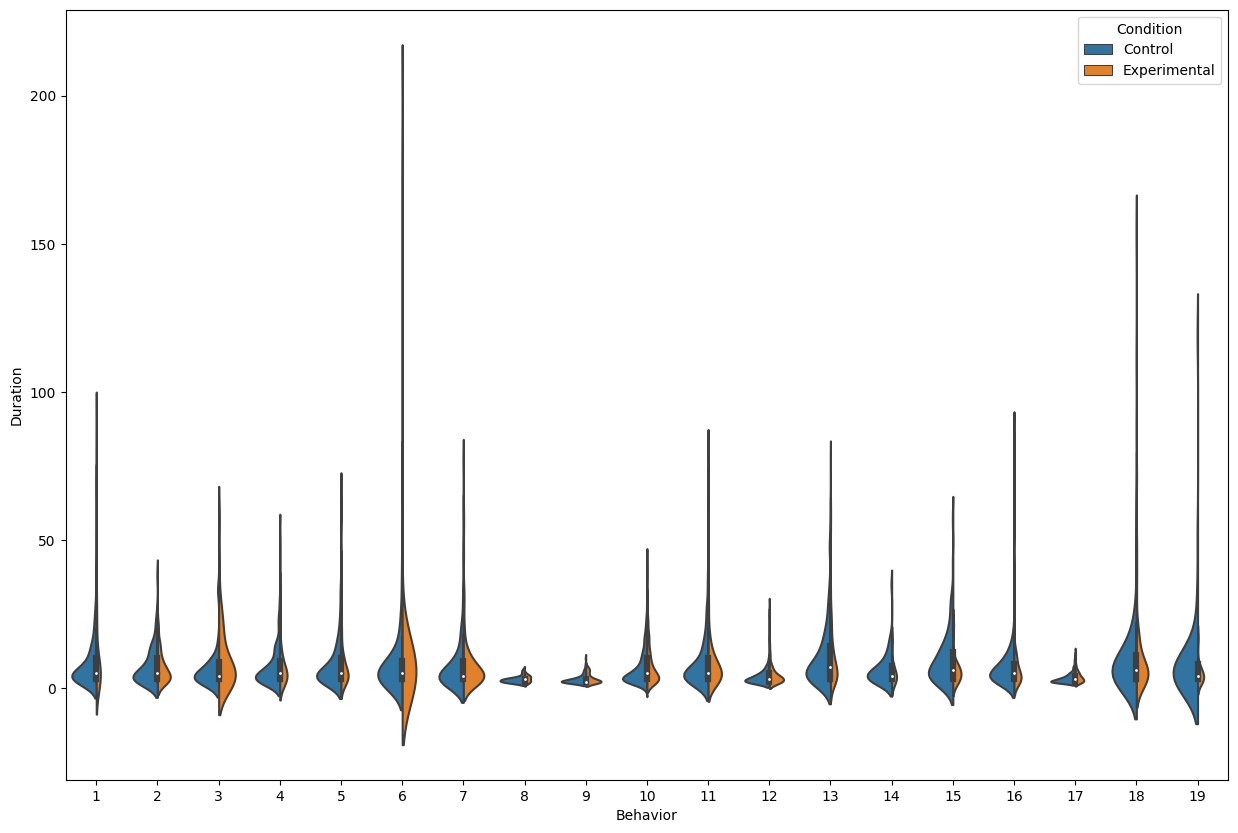

In [153]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# sns.ecdfplot([duration_control, duration_exp], weights=np.arange(2, 12, 0.1), ax=ax)
sns.violinplot(data=df, y='Duration', x='Behavior', hue='Condition', split=True, scale='count', ax=ax)
# sns.swarmplot(data=df, y='Duration', x='Condition', size=1, ax=ax)

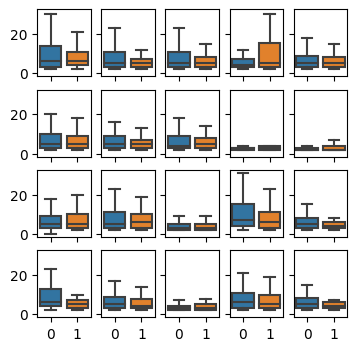

In [38]:
rows = 4
cols = 5
count = 0
fig, ax = plt.subplots(rows, cols, figsize=(4, 4), sharey=True, sharex=True)
for row in range(rows):
    for col in range(cols):
        # control
        idx_of_interest_control = np.where(predictions_control_filtered[np.where(np.diff(predictions_control_filtered[:]) != 0)[0]] == target_of_interests[count])[0]
        durations_all_control = np.diff(np.hstack((0, np.where(np.diff(predictions_control_filtered[:]) != 0)[0])))
        # exp
        idx_of_interest_exp = np.where(predictions_exp_filtered[np.where(np.diff(predictions_exp_filtered[:]) != 0)[0]] == target_of_interests[count])[0]
        durations_all_exp = np.diff(np.hstack((0, np.where(np.diff(predictions_exp_filtered[:]) != 0)[0])))
        duration_control = durations_all_control[idx_of_interest_control]
        duration_exp = durations_all_exp[idx_of_interest_exp]
        
        sns.boxplot([duration_control, duration_exp], showfliers=False, ax=ax[row, col],
                                # showmeans=False, showextrema=False, showmedians=False
                             
                               )
        count += 1 